# CIFAR10 Image Classification with CNN

In this notebook we attempt to classify photos from the widely used [CIFAR10](https://keras.io/api/datasets/cifar10/) dataset. The dataset contains 60,000 images (50,000 training set and 10,000 test set) in 10 categories. The categories are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck and the training and test image sets are divided equally between the categories (5,000 training, 1,000 test each). The images in the dataset are 32x32 pixel RGB images.

With such small images and high intra-class variability, accurate classification is a challenging task. To accomplish this. We train a convolutional neural network (CNN) to attempt to classify the images into the 10 categories. Convolutional Neural Networks (CNNs) are particularly well-suited to image classification tasks because they automatically learn hierarchical features such as edges, textures, and object parts. Our goal is to evaluate the performance of a custom CNN architecture and analyze its strengths and weaknesses.

Data source: https://keras.io/api/datasets/cifar10/


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


# Data Inspection

The class names and their corresponding indices were taken directly from the documentation. While the documentation also specifies the dimensions and counts of images, we need to check to be certain. An inspection of the shape of the data confirms that we have 50,000 training and 10,000 test images of 32 by 32 pixels and 3 chanels for RGB.

In [38]:
raw_data = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = raw_data.load_data()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [40]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Exploratory Data Analysis

We also check the class counts to ensure the classes are well balanced. As the bar charts confirm, both the trainign and test sets are perfectly balanced across classes, so there is no need for any class balancing techniques.

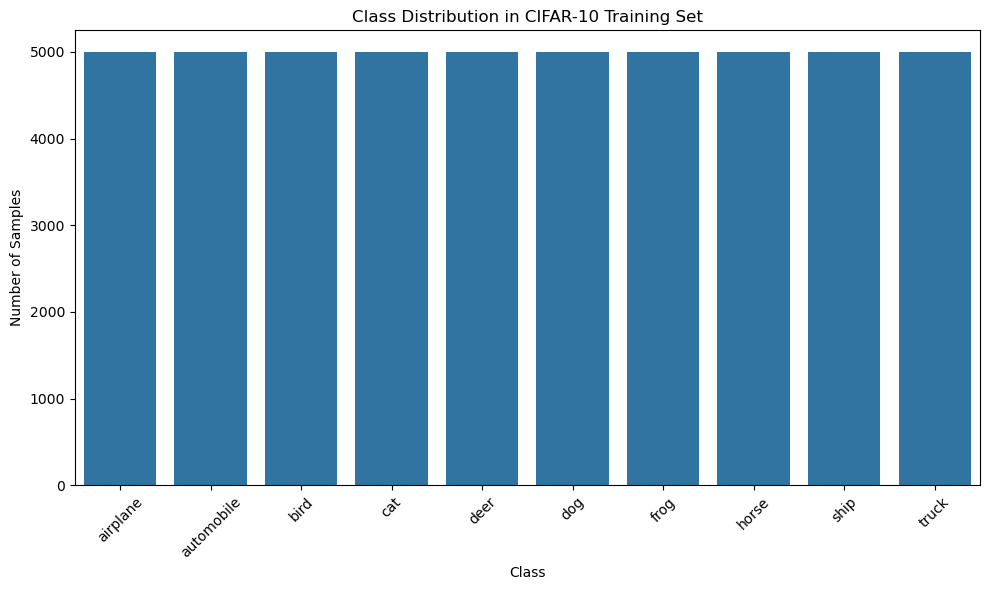

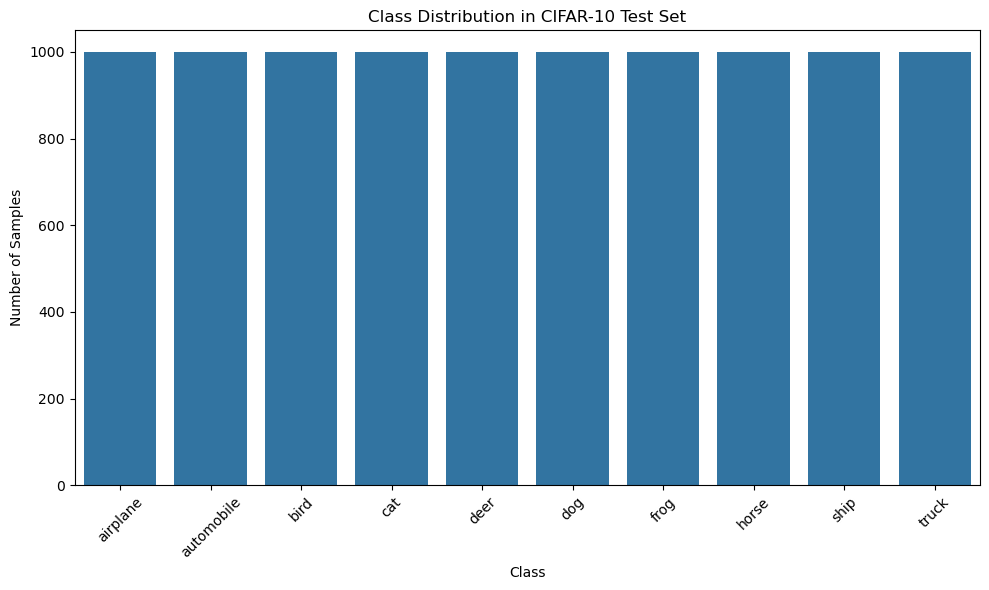

In [ ]:
class_counts_train = np.bincount(y_train.flatten())

# Plot Training distributino
plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=class_counts_train)
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

class_counts_test = np.bincount(y_test.flatten())

# Plot test distribution
plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=class_counts_test)
plt.title('Class Distribution in CIFAR-10 Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We visualize random examples of each of the classes as a sanity check. As one would expect, the 1,024 pixel images are not very clear, but for most images they are clear enough for a human to categorize them. There are some noteable exceptions however, where minus the class label, we would have difficulty saying which class the image belongs to with any certainty.

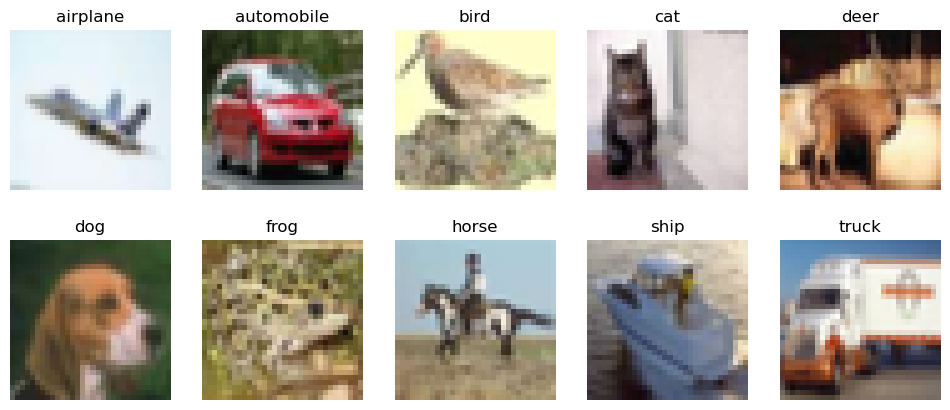

In [ ]:
# Sample Images
plt.figure(figsize=(12, 5))
for i, class_name in enumerate(class_names):

    # random image from each class
    indices = np.where(y_train.flatten() == i)[0]
    idx = np.random.choice(indices)
    img = x_train[idx]

    # plot
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

Finally, we examine the color channels of the images by class to see if there are any obvious trends. The blue channel intensity tends to be higher in airplane and ship images, which is likely explained by more frequent sky and water backgrounds respectively. Airplane images in general tend to be more intense across all channels. A tenuous explanation for this could be that airplane photos tend to be taken towards the sky allowing more sunlight into the camera, but this is merely our amateur theory. Apart from these, there don't seem to be any obvious trends in class versus color meaning our model may have to rely mainly on shapes and physical patterns in the image rather than color.

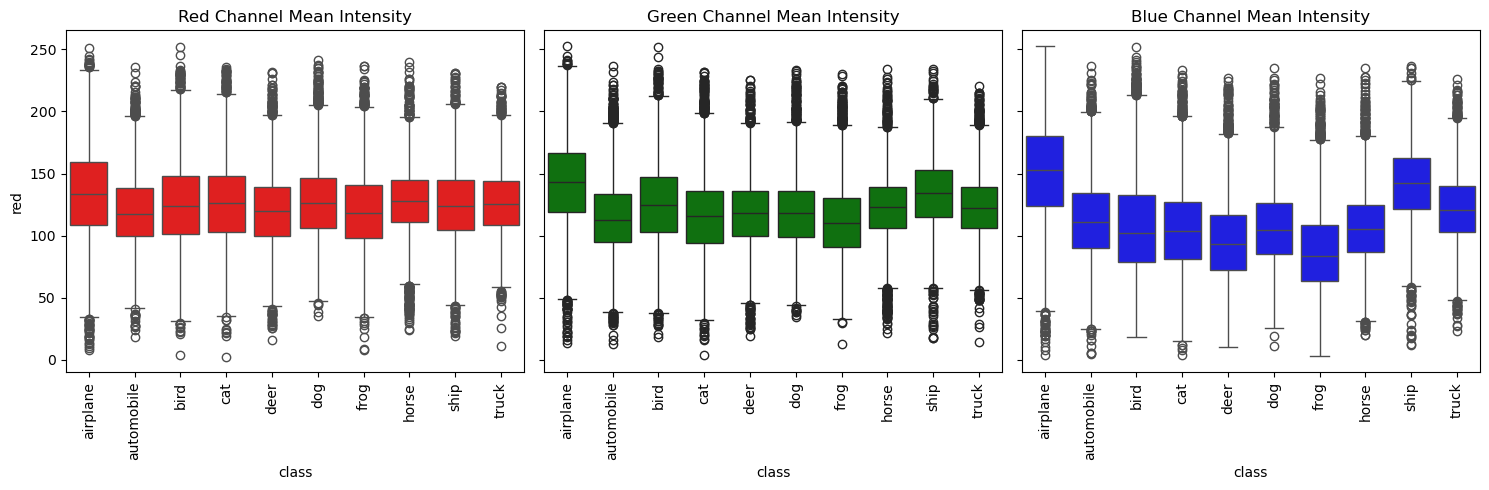

In [ ]:
red_vals = x_train[:, :, :, 0].mean(axis=(1, 2))
green_vals = x_train[:, :, :, 1].mean(axis=(1, 2))
blue_vals = x_train[:, :, :, 2].mean(axis=(1, 2))

df = pd.DataFrame({
    'red': red_vals,
    'green': green_vals,
    'blue': blue_vals,
    'class': y_train.flatten()
})
df['class'] = df['class'].map(dict(enumerate(class_names)))
df = df.sort_values(by='class', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.boxplot(x='class', y='red', data=df, ax=axes[0], color='red')
axes[0].set_title('Red Channel Mean Intensity')
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(x='class', y='green', data=df, ax=axes[1], color='green')
axes[1].set_title('Green Channel Mean Intensity')
axes[1].tick_params(axis='x', rotation=90)

sns.boxplot(x='class', y='blue', data=df, ax=axes[2], color='blue')
axes[2].set_title('Blue Channel Mean Intensity')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# Models

Our main strategy was to start with a simple "baseline" CNN to give an idea of what a very simple model could do. From there we would add (or later subtract) layers to find a model that could provide over 0.8 accuracy.

We chose a CNN architecture for this project because it is specifically designed to handle image data efficiently and accurately. CNNs are excellent at detecting patterns in images and that is precisely what this task requires. Importantly CNNs are good at recognizing these patterns even if they appear in different parts of images or are flipped or rotated by some degree. As this is an introduction to deep learning class, the CNNs we will use will be relatively simple, but among the architectures we studied, CNNs are unrivaled at computer vision tasks.

To begin we prepared the data by splitting the training data into a training (0.8) and validation (0.2) set during training. The trained model would then be used on the test data from the original dataset. In order to avoid overfitting we introduced some data augmentation techniques. We introduced random flips and across the y-axis and random translations. This improved model performance. Other data augmentation techniques such as random rotations and random were tried, but these seemed to significantly harm both the model's convergence and its generalizability. Our explanation for this is the size of the dataset images. With such small images, these distortions likely introduce a more significant change to the image than a similarly scaled distortion on a large image. In other words, the model already doesn't have much to work with, taking anything away makes the job of classification significantly harder.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 125
epochs = 100
patience = 10

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    #layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

X, x_val, Y, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

y_cat = to_categorical(Y, num_classes=10)
y_val_cat = to_categorical(y_val, num_classes=10)

train_ds = tf.data.Dataset.from_tensor_slices((X, y_cat))
train_ds = train_ds.shuffle(buffer_size=4000)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, tr81aining=True), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_cat))
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

In [45]:
## Functions for plotting results

def get_training_values(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc)+1)
    return acc, val_acc, loss, val_loss, epochs_range

def plot_history(history):
    acc, val_acc, loss, val_loss, epochs_range = get_training_values(history)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Simple model (baseline)

We started with a simple CNN model based on the basic model demonstrated in the class lectures. It consists of 3 convolutional layers joined by 2D max pooling layers. The convolutional layers are our feature detectors and the max pooling to keep only the strongest detected features. This is follwed by a 2 layer fully connected network with an output vector of length 10. The 10 variables in the output vector represent the model's estimation of the the probabilty that the image contains that class.

### Training

In [69]:
def create_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3492 - loss: 2.2207 - val_accuracy: 0.4630 - val_loss: 1.4916
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4594 - loss: 1.4972 - val_accuracy: 0.5179 - val_loss: 1.3515
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5120 - loss: 1.3653 - val_accuracy: 0.5352 - val_loss: 1.3099
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5503 - loss: 1.2673 - val_accuracy: 0.5707 - val_loss: 1.2275
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5786 - loss: 1.1905 - val_accuracy: 0.6075 - val_loss: 1.1086
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5962 - loss: 1.1387 - val_accuracy: 0.6447 - val_loss: 1.0246
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6148 - loss: 1.0920 - val_accuracy: 0.6512 - val_loss: 1.0055
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6310 - loss: 1.0503 - val_accu

### Results

As expected the model performed much better than random chance, but still left a lot to be desired. For such a lightweight, shallow network it achieved a respectable 0.76 accuracy in classifying the test set. As we can see in the confusion matrix below, the model did struggle slightly in distinguishing cats and dogs. In fact, the model had a little more difficulty in identifying cats compared to any other class, as demonstrated in the bar chart of misclassifications below. With this model as a starting point, we attempted to expand the model's layers to achieved a better predictive model, our personal goal being above 0.8 accuracy.

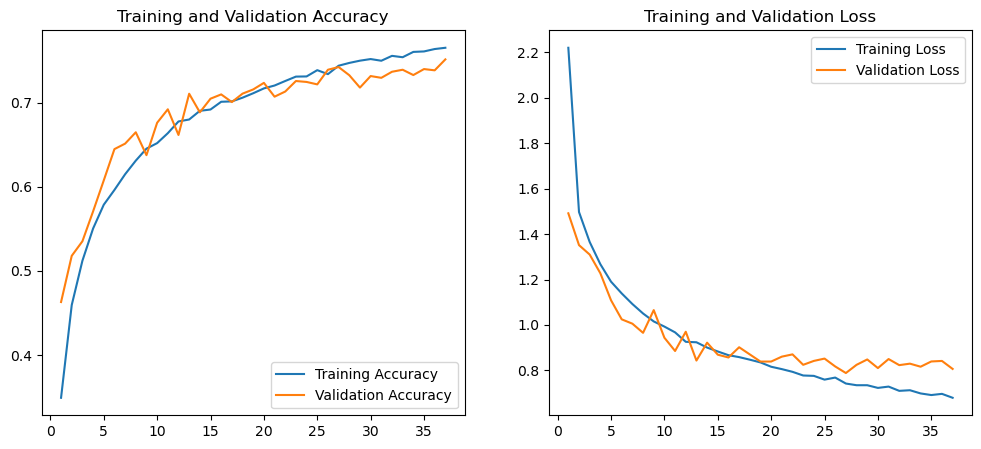

In [49]:
plot_history(history)

In [50]:
# Predict Test set labels
y_pred = np.argmax(model.predict(x_test), axis=1)
df = pd.DataFrame({'true': y_test.flatten(), 'pred': y_pred.flatten()})

# Classifcation Report
cr = classification_report(df['true'], df['pred'], target_names=class_names)
print(cr)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.76      0.79      0.77      1000
  automobile       0.83      0.89      0.86      1000
        bird       0.71      0.60      0.65      1000
         cat       0.59      0.53      0.56      1000
        deer       0.73      0.68      0.70      1000
         dog       0.68      0.61      0.64      1000
        frog       0.68      0.88      0.77      1000
       horse       0.77      0.79      0.78      1000
        ship       0.83      0.85      0.84      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



<Axes: >

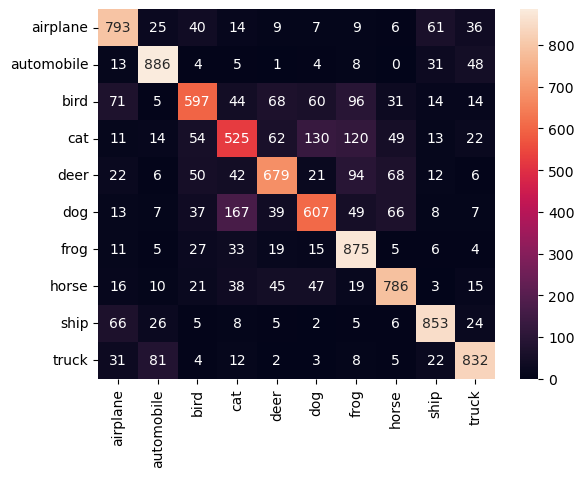

In [51]:
## Confusion matrix for predictions on test set
cm = confusion_matrix(df['true'], df['pred'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

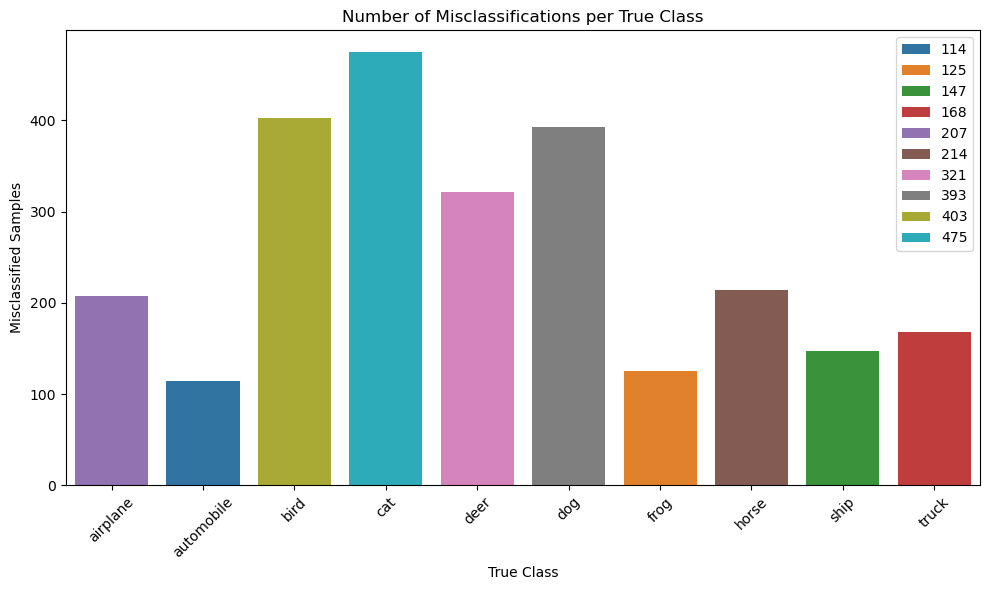

In [ ]:
# Flatten y_test to 1D
y_test_flat = y_test.flatten()

# identify misclassified
misclassified_mask = y_pred != y_test_flat
y_true_mis = y_test_flat[misclassified_mask]
y_pred_mis = y_pred[misclassified_mask]

# Count misclassified by class
mis_counts = np.bincount(y_true_mis, minlength=len(class_names))

plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=mis_counts, palette='tab10', hue=mis_counts)
plt.title('Number of Misclassifications per True Class')
plt.xlabel('True Class')
plt.ylabel('Misclassified Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Improved model

With our baseline results set, we attempted to develop a model with significantly better performance. The first step was to extend each convolutional block by adding a second convolutional layer and introduce batch normalization after each one. As stated above the convolutional layers learn the features and the batch normalization was included to stabilize the training. The presence of a second convolutional layer in each block should allow the model to learn more abstract and complex features which should allow it to better recognize each of the 10 classes. We also included dropout layers at the end of each block in order to prevent overfitting.

### Training

In [53]:
def build_better_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization(  )(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [54]:
model_b = build_better_model()
model_b.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_b.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,02

 Total params: 856,938 (3.27 MB)

 Trainable params: 855,146 (3.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history_b = model_b.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.2410 - loss: 2.2531 - val_accuracy: 0.3207 - val_loss: 1.8495
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3882 - loss: 1.6467 - val_accuracy: 0.5001 - val_loss: 1.3951
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4762 - loss: 1.4390 - val_accuracy: 0.5290 - val_loss: 1.3431
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5373 - loss: 1.2963 - val_accuracy: 0.5743 - val_loss: 1.1871
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5854 - loss: 1.1864 - val_accuracy: 0.6127 - val_loss: 1.1120
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6242 - loss: 1.0981 - val_accuracy: 0.6368 - val_loss: 1.0131
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6528 - loss: 1.0242 - val_accuracy: 0.7041 - val_loss: 0.8561
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6727 - loss: 0.9685 - v

### Results

Our improved model clearly outperformed the baseline model. It reached an accuracy of 0.87, surpassing our goal of 0.8. The validation accuracy and loss closely followed the training set accuracy and loss, suggesting that this is a good generalized predictor that is not overfitting or simply memorizing the training images.

As with the previous model, the most challenging distinction was between cats and dogs with 134 misclassifications between the two (101 cats and 33 dogs were wrongly classified). Cats in general were the most misclassified.

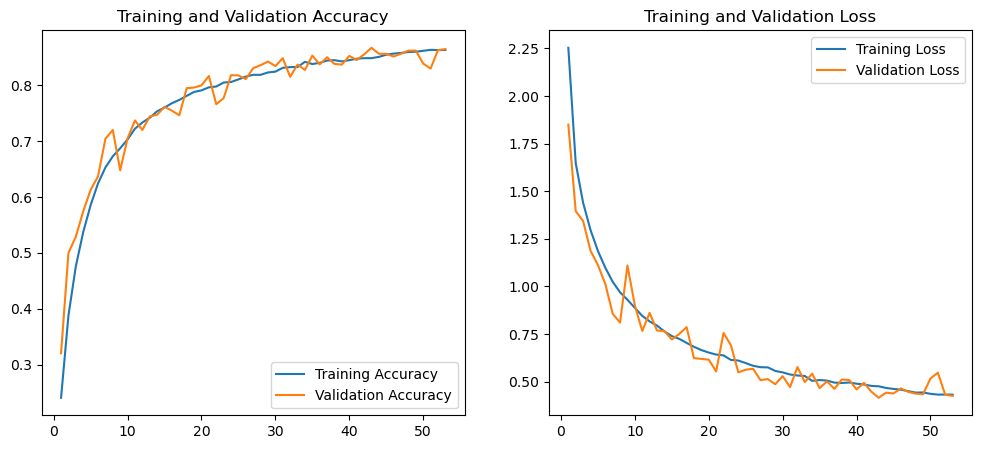

In [56]:
plot_history(history_b)

In [57]:
# Predict labels
y_pred = np.argmax(model_b.predict(x_test), axis=1)
df_b = pd.DataFrame({'true': y_test.flatten(), 'pred': y_pred.flatten()})

# Classifcation Report of predictions
cr_b = classification_report(df_b['true'], df_b['pred'], target_names=class_names)
print(cr_b)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.83      0.78      0.80      1000
         cat       0.77      0.67      0.72      1000
        deer       0.86      0.82      0.84      1000
         dog       0.77      0.81      0.78      1000
        frog       0.79      0.94      0.86      1000
       horse       0.90      0.88      0.89      1000
        ship       0.92      0.93      0.93      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



<Axes: >

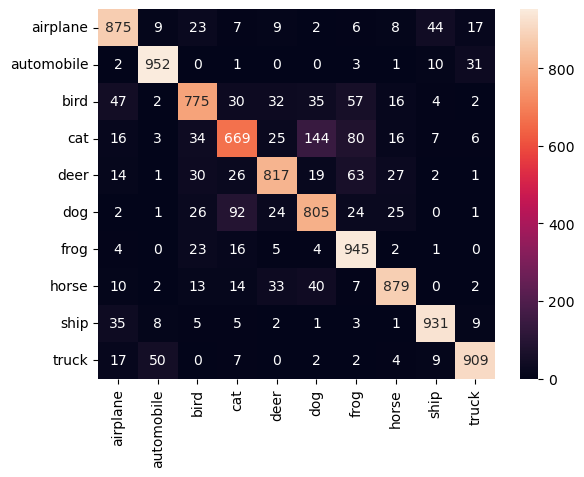

In [58]:
## Confusion matrix for predictions on test set

cm_b = confusion_matrix(df_b['true'], df_b['pred'])
sns.heatmap(cm_b, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

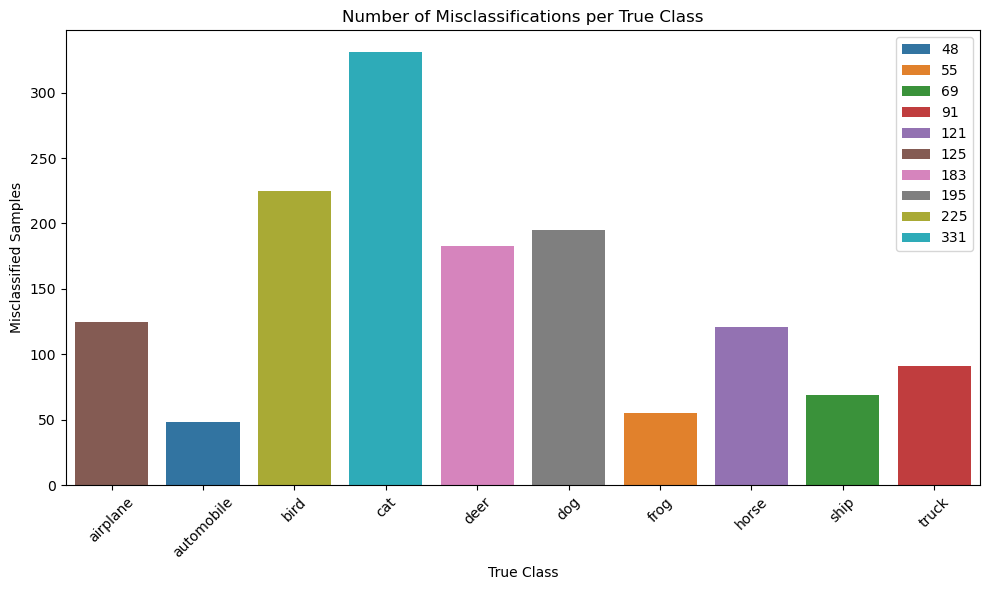

In [ ]:
# Flatten y_test to 1D
y_test_flat = y_test.flatten()

# identify misclassified
misclassified_mask = y_pred != y_test_flat
y_true_mis = y_test_flat[misclassified_mask]
y_pred_mis = y_pred[misclassified_mask]

# Count misclassified by class
mis_counts = np.bincount(y_true_mis, minlength=len(class_names))

plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=mis_counts, palette='tab10', hue=mis_counts)
plt.title('Number of Misclassifications per True Class')
plt.xlabel('True Class')
plt.ylabel('Misclassified Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Resnet-Style model

While researching for this project, the authors came across an article titled "[A Practical Comparison Between CNN and ResNet Architectures: A Focus on Attention Mechanisms
](https://medium.com/@leonardofonseca.r/a-practical-comparison-between-cnn-and-resnet-architectures-a-focus-on-attention-mechanisms-cee7ec8eca55)" that compared a standard CNN to a ResNet like architecture for classifying cat and dog images. This inspired us to adapt their approach for our own dataset. The key architectural difference between our earlier CNN and this ResNet implementation lies in the introduction of residual blocks with skip connections. In a conventional CNN, each convolutional block processes its input and passes the transformed output directly to the next layer. In contrast, in a ResNet block the output of the convolutional path is added to the original input before applying the activation function. This “shortcut” connection allows the network to preserve information from earlier layers, reducing the risk of losing important features and mitigate the vanishing gradient problem.

Each residual block ressembles our convolutional blocks from the previous model with two convolutional layers, each followed by batch normalization and dropout. The key difference is the skip path which is included after the second convolution-batch normalization pair. The dense layer mirrors our CNN exactly.

In [ ]:
def residual_block(x, filters, dropout_rate=0.0):
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)

    # Main path
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    return x

def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # Residual blocks
    x = residual_block(inputs, 32, dropout_rate=0.25)
    x = residual_block(x, 64, dropout_rate=0.25)
    x = residual_block(x, 128, dropout_rate=0.25)

    # Fully connected blocks
    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

### Training

In [61]:
#model_r = build_resnet(depth=8)
model_r = build_resnet()
model_r.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_r.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │        128 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dropout_17[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │      2,112 │ dropout_17[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 32, 32,    │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32, 32,    │          0 │ re_lu_4[0][0]   

 Total params: 33,889,770 (129.28 MB)

 Trainable params: 33,888,106 (129.27 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [62]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history_r = model_r.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.2889 - loss: 2.1529 - val_accuracy: 0.2927 - val_loss: 2.0622
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4039 - loss: 1.6274 - val_accuracy: 0.4203 - val_loss: 1.6407
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.4738 - loss: 1.4374 - val_accuracy: 0.5567 - val_loss: 1.2260
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.5319 - loss: 1.3031 - val_accuracy: 0.5824 - val_loss: 1.1516
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.5731 - loss: 1.1963 - val_accuracy: 0.5932 - val_loss: 1.1614
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.6110 - loss: 1.0976 - val_accuracy: 0.6862 - val_loss: 0.8876
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.6391 - loss: 1.0251 - val_accuracy: 0.6965 - val_loss: 0.8749
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.6610 - loss: 0

### Results

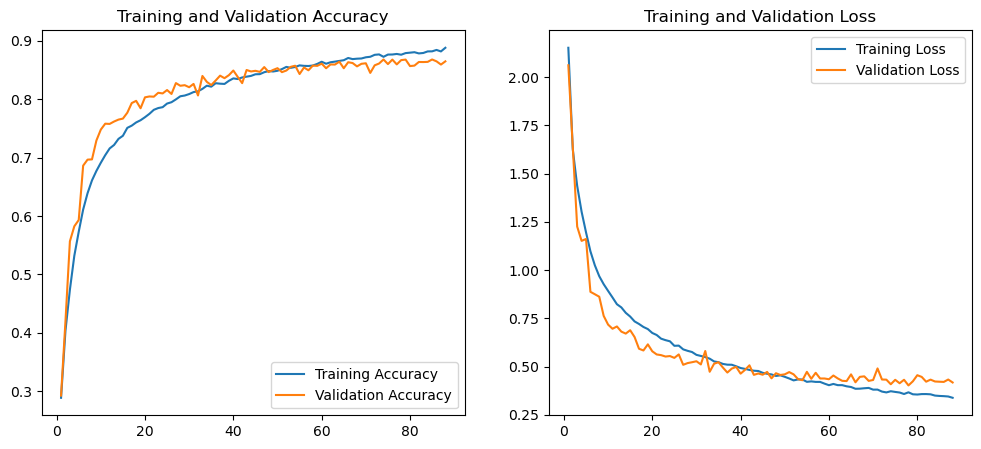

In [63]:
plot_history(history_r)

In [64]:
# Predict test labels
y_pred = np.argmax(model_r.predict(x_test), axis=1)
df_r = pd.DataFrame({'true': y_test.flatten(), 'pred': y_pred.flatten()})

# Classifcation report
cr_r = classification_report(df_r['true'], df_r['pred'], target_names=class_names)
print(cr_r)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

    airplane       0.88      0.85      0.86      1000
  automobile       0.90      0.96      0.93      1000
        bird       0.85      0.77      0.80      1000
         cat       0.76      0.74      0.75      1000
        deer       0.85      0.82      0.84      1000
         dog       0.81      0.80      0.80      1000
        frog       0.84      0.93      0.88      1000
       horse       0.86      0.90      0.88      1000
        ship       0.93      0.90      0.91      1000
       truck       0.90      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



<Axes: >

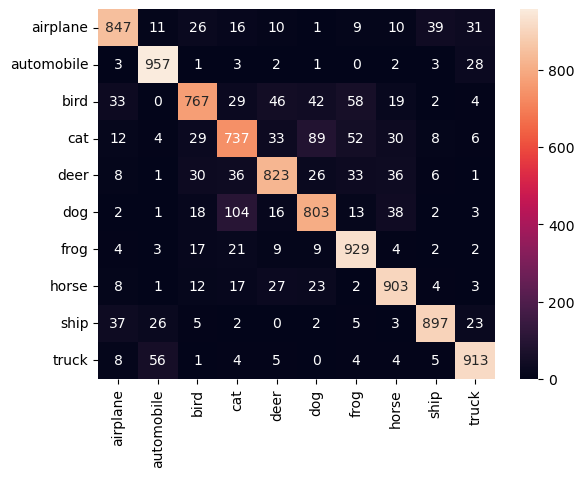

In [65]:
## Confustion matrix for predictions on test set
cm_r = confusion_matrix(df_r['true'], df_r['pred'])
sns.heatmap(cm_r, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

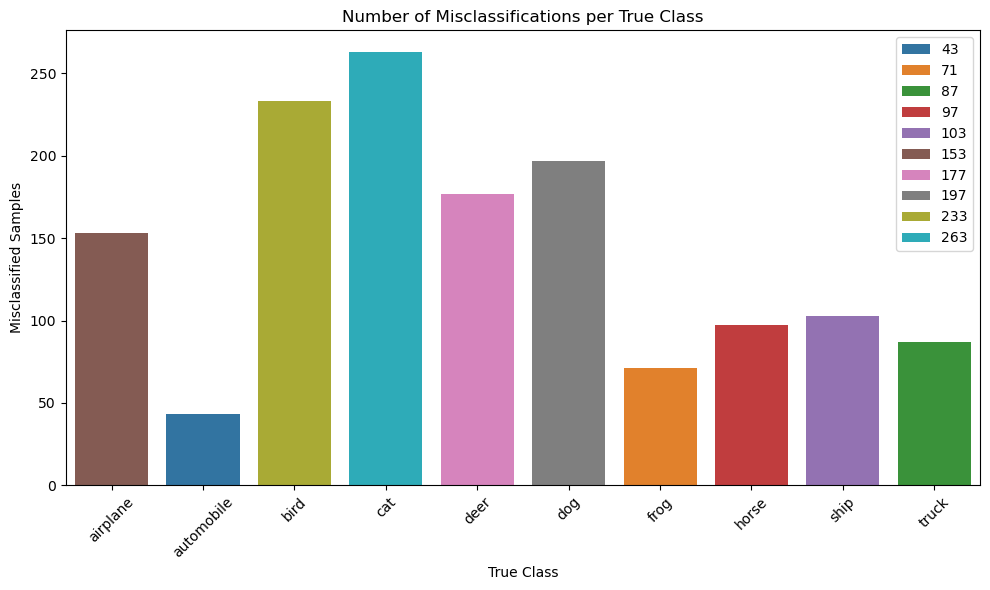

In [ ]:
# Flatten y_test to 1D
y_test_flat = y_test.flatten()

# identify misclassified
misclassified_mask = y_pred != y_test_flat
y_true_mis = y_test_flat[misclassified_mask]
y_pred_mis = y_pred[misclassified_mask]

# Count misclassified by class
mis_counts = np.bincount(y_true_mis, minlength=len(class_names))

plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=mis_counts, palette='tab10', hue=mis_counts)
plt.title('Number of Misclassifications per True Class')
plt.xlabel('True Class')
plt.ylabel('Misclassified Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Results and Discussion

Our results show that a relatively simple CNN can achieve strong performance on CIFAR-10. This highlights the effectiveness of convolutional layers in extracting visual features, even from small, low-resolution images where those features are less distinct compared to larger datasets.

We also experimented with residual connections inspired by the ResNet architecture. In our case, these connections did not provide clear performance benefits, which contrasts with findings from other studies, including the article on which our ResNet-inspired model was based. However, our architecture was relatively lightweight; it is possible that larger, deeper, or more state-of-the-art networks would benefit more from residual connections. Importantly, the addition of residual connections did not harm performance in any significant way.

A key limitation observed was the model’s difficulty with fine-grained distinctions between visually similar classes. For example, cats and dogs share many features and often appear against similar backgrounds, leading to higher misclassification rates between these classes. Similarly, cars and trucks were sometimes confused, as they share structural similarities and background contexts. Notably, cats were misclassified more often than any other class.

To better understand these misclassifications, we examined Grad-CAM visualizations of several randomly selected cat images. Grad-CAM overlays a heatmap onto the original image, highlighting the regions that most strongly influenced the model’s decision. Warmer colors (red, orange, yellow) indicate areas of high influence, while cooler colors (blue, purple) indicate low influence. In many of the cat images, the heatmaps suggested that the model was paying more attention to the background than to the animal itself. This suggests that the CNN may be relying too heavily on contextual cues rather than focusing on the defining features of the object.

Overall, these findings suggest that while our CNN is effective at learning general visual patterns in CIFAR-10, it still struggles with subtle, fine-grained distinctions and occasionally relies on background context rather than the object itself. This highlights both the strengths and limitations of our approach, setting the stage for potential improvements through more advanced architectures, more robust data augmentation, or transfer learning.

Last convolutional layer name: conv2d_26


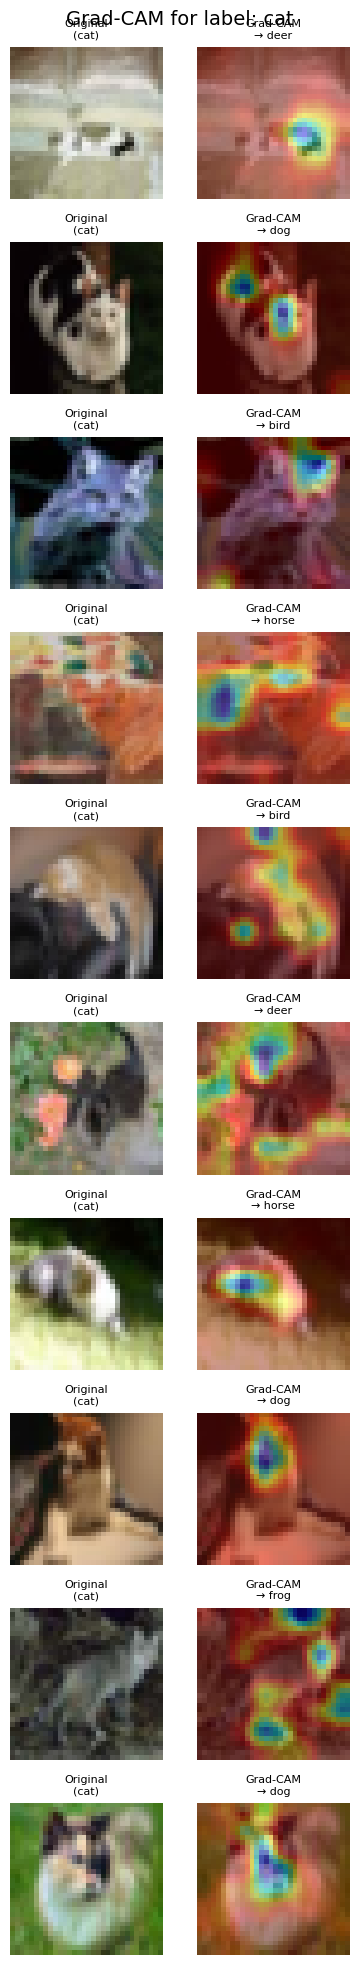

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer, and the model's output
    last_conv_layer = next(layer for layer in reversed(model_b.layers) if isinstance(layer, layers.Conv2D))
    last_conv_layer_name = last_conv_layer.name

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the target class w.r.t. the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps by the importance of each channel
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4, cmap='jet'):
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert original image to RGB if needed
    #if img.shape[-1] == 1:
    #    img = np.repeat(img, 3, axis=-1)

    # Ensure both are uint8
    #img = np.uint8(255 * img)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

cat_indices = np.where(y_test == 3)[0]
misclassified_cat_indices = [i for i in cat_indices if y_pred[i] != 3]
selected_indices = np.random.choice(misclassified_cat_indices, size=10, replace=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
label_choice = 3

# Get last convolutional layer name
last_conv_layer = next(layer for layer in reversed(model_b.layers)
                       if isinstance(layer, layers.Conv2D))
last_conv_layer_name = last_conv_layer.name

print("Last convolutional layer name:", last_conv_layer_name)

fig, axes = plt.subplots(10, 2, figsize=(4, 20))
fig.suptitle(f"Grad-CAM for label: {class_names[label_choice]}", fontsize=14)

for ax_pair, idx in zip(axes, selected_indices):
    img = x_test[idx]
    img_array = np.expand_dims(img, axis=0)

    # Generate heatmap and overlay on image
    heatmap = make_gradcam_heatmap(img_array, model_b, last_conv_layer_name)
    gradcam_img = display_gradcam(img, heatmap)

    # Plot Original image
    ax_pair[0].imshow(img)
    ax_pair[0].set_title("Original\n(cat)", fontsize=8)
    ax_pair[0].axis('off')

    # Plot Grad-CAM image
    ax_pair[1].imshow(gradcam_img)
    ax_pair[1].set_title(f"Grad-CAM\n→ {class_names[y_pred[idx]]}", fontsize=8)
    ax_pair[1].axis('off')

plt.tight_layout()
plt.show()

# Conclusions

This project demonstrated that CNNs can achieve strong performance on the CIFAR-10 dataset, even with relatively simple architectures. While residual connections did not significantly improve results in our lightweight model, they remain a promising direction for deeper networks.

The main challenges were in fine-grained class distinctions (e.g., cats vs. dogs) and the model’s tendency to rely on background features, as revealed by Grad-CAM visualizations. These findings suggest that while the approach is effective overall, there is room for improvement.

Future work should explore more robust data augmentation, further hyperparameter tuning, and transfer learning with deeper architectures to further improve accuracy and robustness.

# References

CIFAR-10 Data source: https://keras.io/api/datasets/cifar10/


[A Practical Comparison Between CNN and ResNet Architectures: A Focus on Attention Mechanisms
](https://medium.com/@leonardofonseca.r/a-practical-comparison-between-cnn-and-resnet-architectures-a-focus-on-attention-mechanisms-cee7ec8eca55)